# Imports

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares, UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL
except:
  Exception('Error Initialising Iminuit')

In [2]:
import os
from IPython.display import Latex
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from funcs import *
from stats import *
from Fit import *

# Functions

In [3]:
def analize(path, init=0, verbose=False):
    CH1, SGN, MTH = get_data(path)
    N = init

    max_CH1, i_max_CH1 = find_max(CH1[1], N, prec=0.00001)
    max_SGN, i_max_SGN = find_max(SGN[1], N, prec=0.00001)
    max_MTH, i_max_MTH = find_max(MTH[1], N, prec=0.00001)
    z, i_zero_CH1 = find_zero(CH1[1], N, prec=0.00001)
    z, i_zero_SGN = find_zero(SGN[1], N, prec=0.00001)
    z, i_zero_MTH = find_zero(MTH[1], N, prec=0.00001)

    V_CH1_SGN = max_CH1/max_SGN
    V_MTH_SGN = max_MTH/max_SGN

    zero_CH1 = (CH1[0][i_zero_CH1]+CH1[0][i_zero_CH1+1])/2
    zero_SGN = (SGN[0][i_zero_SGN]+SGN[0][i_zero_SGN+1])/2
    zero_MTH = (MTH[0][i_zero_MTH]+MTH[0][i_zero_MTH+1])/2

    dt_CH1_SGN = np.abs(zero_CH1 - zero_SGN)
    dt_MTH_SGN = np.abs(zero_MTH - zero_SGN)

    if verbose:
        return CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, zero_CH1, zero_SGN, zero_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH
    
    else:
        return V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN


# RC

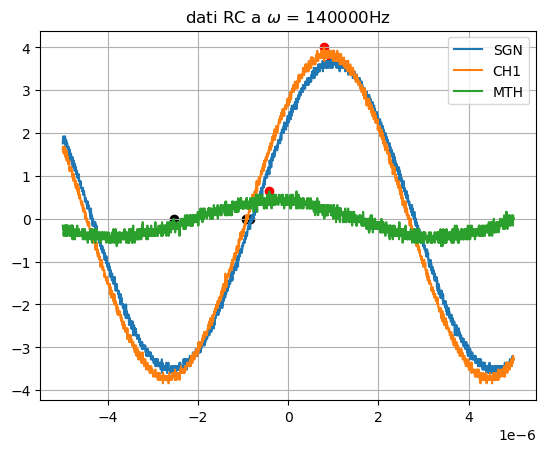

In [4]:
path = 'data/RC/140000/'
CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, zero_CH1, zero_SGN, zero_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH = analize(path, 200, True)

plt.plot(SGN[0], SGN[1], label='SGN')
plt.plot(CH1[0], CH1[1], label='CH1')
plt.plot(MTH[0], MTH[1], label='MTH')
plt.scatter(CH1[0][i_max_CH1], max_CH1, color='red')
plt.scatter(MTH[0][i_max_MTH], max_MTH, color='red')
plt.scatter(CH1[0][i_zero_CH1], zero_CH1, color='k')
plt.scatter(SGN[0][i_zero_SGN], zero_SGN, color='k')
plt.scatter(MTH[0][i_zero_MTH], zero_MTH, color='k')
plt.scatter(SGN[0][i_max_SGN], 3.76, color='r')
plt.title(r"dati RC a $\omega$ = 140000Hz")
plt.grid()
plt.legend()

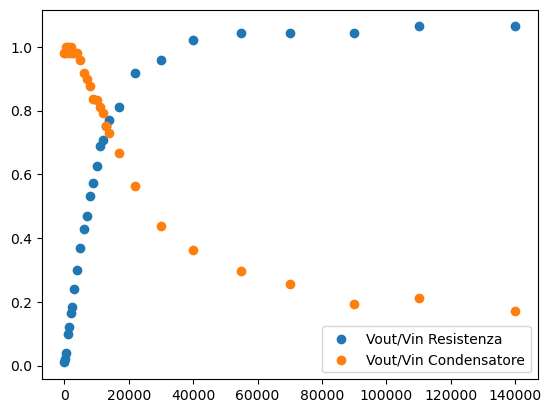

In [5]:
V_res_all, dt_res_all, freqs = [], [], []
V_c_all, dt_c_all = [], []

for i in os.listdir('data/RC'):
    path = 'data/RC/'+i+'/'
    V_CH1_RES, V_C_SGN, dt_RES_SGN, dt_C_SGN = analize(path, 300, False)
    V_res_all.append(V_CH1_RES)
    V_c_all.append(V_C_SGN)
    dt_res_all.append(dt_RES_SGN*float(i))
    dt_c_all.append(dt_C_SGN*float(i))
    freqs.append(float(i))

freqs = np.array(freqs)
V_res_all = np.array(V_res_all)
plt.scatter(freqs,V_res_all, label='Vout/Vin Resistenza')
plt.scatter(freqs,V_c_all, label='Vout/Vin Condensatore')
plt.legend()

In [6]:
def H_R(w,R,C, a):
    return w*R*C/np.sqrt(1+(w**2 * R**2 * C**2)) + a

In [7]:
def H_R_2(w,tau, a):
    return w*tau/np.sqrt(1+(w**2 * tau**2)) + a

In [8]:
y = [H_R(i, 996, 12e-9, 0.07) for i in freqs*2*np.pi]
plt.scatter(freqs,y, label='modello')
plt.scatter(freqs,V_res_all, label='dati')
plt.legend()
plt.close()

[7.23889609e-05 3.97096167e-02]
[1.90828420e-05 6.44909752e-02]
5.56425885799713


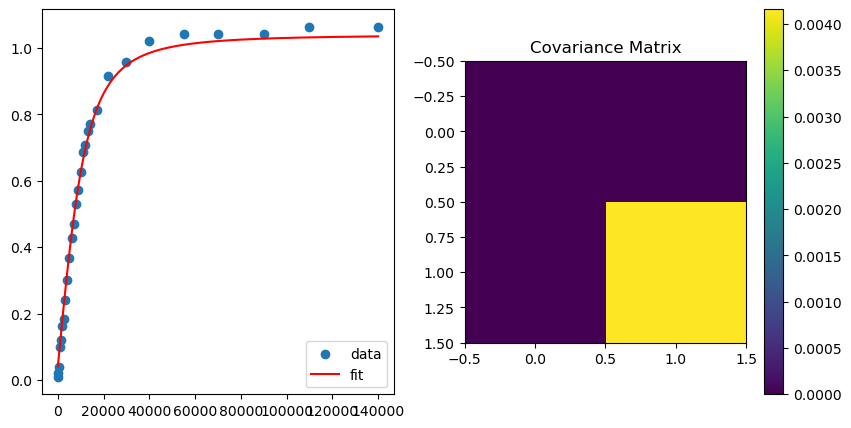

In [24]:
f = Fit(freqs, V_res_all, H_R_2, 0.2, kwargs={'tau':1e-3, 'a':0.07})
f.fit(scipy=True)
f.visualize()
print(f.values)
print(f.errors)
print(f.fval / f.ndof)

In [15]:
def H_C(w,tau, a):
    return 1/np.sqrt(1+(w**2 * tau**2)) + a

[6.60934657e-05 5.50966176e-03]
[1.93594348e-05 6.22336126e-02]
5.888812704963085


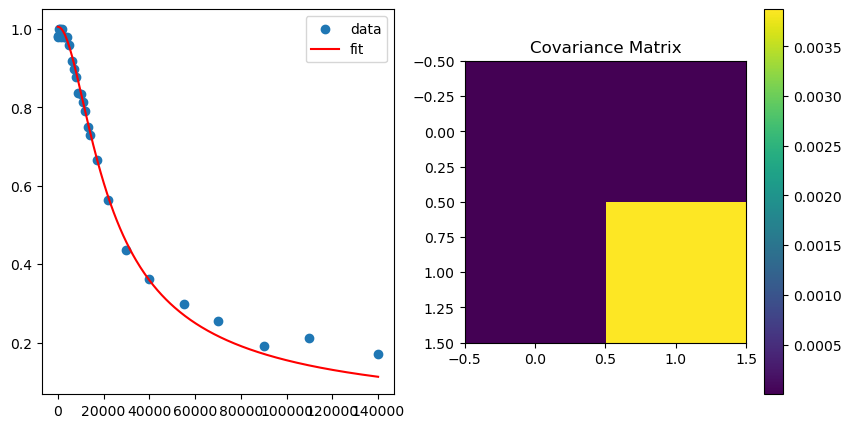

In [20]:
f = Fit(freqs, V_c_all, H_C, 0.2, kwargs={'tau':1e-3, 'a':0.07})
f.fit(scipy=True)
f.visualize()
print(f.values)
print(f.errors)
print(f.fval / f.ndof)

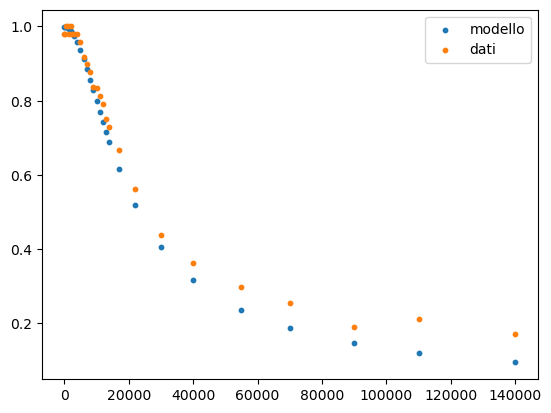

In [ ]:
y = [H_C(i, 996*12e-9, -0.0001) for i in freqs*2*np.pi]
plt.scatter(freqs,y, label='modello', s=10)
plt.scatter(freqs,V_c_all, label='dati', s=10)
plt.legend()

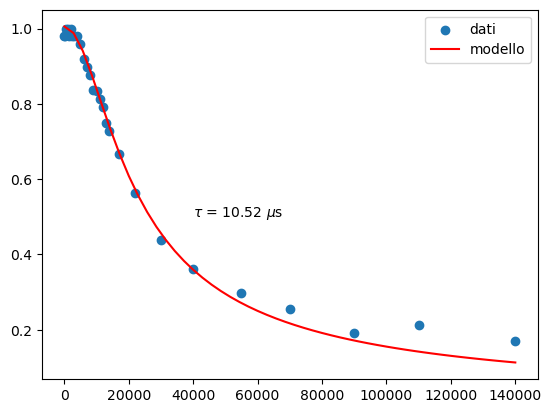

Tau, a =  [1.05191085e-05 5.50976956e-03]
C =  10.519108502028642 nF


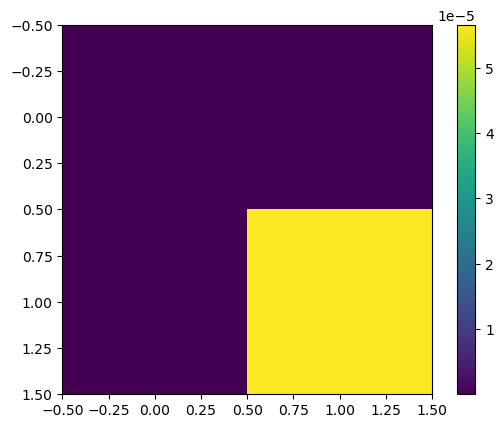

In [ ]:
popt, pcov = curve_fit(H_C, freqs*2*np.pi, V_c_all, p0=[12e-6, -0.0001], sigma=0.05*np.ones(len(freqs)))
plt.scatter(freqs,V_c_all, label='dati')
x = np.linspace(np.min(freqs), np.max(freqs))
plt.plot(x,H_C(x*2*np.pi, *popt), label='modello', color='red')
plt.text(40000, 0.5, r'$\tau$ = %.2f $\mu$s' % (popt[0]*1e6))
plt.legend()
plt.show()
plt.imshow(pcov)
plt.colorbar()
print("Tau, a = ", popt)
print("C = ", popt[0]*1e6, "nF")

In [ ]:
c = LeastSquares(freqs*2*np.pi,V_c_all,0.05, H_C, verbose=False)
m = Minuit(c, R=997, C=12e-9, a=-.0)
m.migrad(iterate=10)
m.minos()
m.hesse()

RuntimeError: R is not one of the parameters [tau a]

# RL

In [ ]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RL'):
    path = 'data/RL/'+i+'/'
    mod, fase = analize(path, 300)
    mods.append(mod)
    fases.append(fase)
    freqs.append(float(i))

mods.pop()
fases.pop()
freqs.pop()
plt.scatter(freqs,mods)

ValueError: too many values to unpack (expected 2)